# Scenario A - Noise Level Variation

In this scenario the noise level on a generated dataset is varied in three steps: low/medium/high, 
the rest of the parameters in the dataset is kept constant.

The model used in the inference of the parameters is formulated as follows: 

\begin{equation}
\large y = f(x) = \sum\limits_{m=1}^M \big[A_m \cdot e^{-\frac{(x-\mu_m)^2}{2\cdot\sigma_m^2}}\big] + \epsilon
\end{equation}

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

#az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.8


## Import local utility functions

In [2]:
import datetime
import os
import sys
sys.path.append('../../utils')
import utils as utl
import datagen as dg
import models as mdl
import results as res
import figures as fig

## Local settings

In [3]:
# output for results and images
out_path      = './output_nopeak_adapt_diag/'
fbase         = 'scenario_noise'
file_basename = out_path + fbase
        
# if dir does not exist, create it
if not os.path.exists(out_path):
    os.makedirs(out_path)

# initialization method for sampler ('jitter+adapt_diag'/'advi+adapt_diag'/'adapt_diag')
init_mode = 'adapt_diag'
    
# provide peak positions to the model as testvalues ('yes'/'no')
peak_info = 'no'

# model mode ('train'/eval')
model_mode = 'train'

# data mode ('generate'/'preload')
data_mode = 'preload'

# dataset directory
dataset_dir = './input_datasets'

## Save configuration

In [4]:
fp = open(out_path + 'settings.txt', 'w')
fp.write('start: ' + datetime.datetime.now().strftime("%A, %d. %B %Y %I:%M%p") + '\n')
fp.write('init_mode  = ' + init_mode + '\n')
fp.write('peak_info  = ' + peak_info + '\n')
fp.write('model_mode = ' + model_mode + '\n')
fp.write('data_mode  = ' + data_mode + '\n')
if data_mode == 'preload':
    fp.write('data_dir   = ' + dataset_dir + '\n')
fp.close()

# Generate data and plot

In [5]:
# list of wavelengths (x-values)
xval = [i for i in range(200, 400, 2)]

ldata  = []
lpeaks = []
lnoise = []
nsets  = 10

# noise level is 1%, 2% and 5% of the minimal signal amplitude
noise_levels = [0.05, 0.10, 0.25]

# total number of datasets
tsets = nsets * len(noise_levels)

# real noise level list
for nl in noise_levels:
    for i in range(nsets):
        lnoise.append(nl)
        
if model_mode == 'train' and data_mode == 'generate':
    # generate the datasets
    for nl in noise_levels:
        for i in range(nsets):
            df, peaks = dg.data_generator(xvalues=xval, nsamples=15, noise=nl)
            ldata.append(df)
            lpeaks.append(peaks)
    # save data to disk
    for i in range(len(ldata)):
        ldata[i].to_csv(out_path + '/dataset_%02d.csv' % (i+1), index=False)
        np.savetxt(out_path + '/peakinfo.csv', lpeaks, delimiter=',')
        
elif model_mode == 'train' and data_mode == 'preload':           
    # load pre-generated datasets from disk
    ldata, lpeaks = dg.data_load(tsets, dataset_dir)
    
else:        
    # load data from disk
    if data_mode == 'preload':
        ldata, lpeaks = dg.data_load(tsets, dataset_dir)
    else:
        ldata, lpeaks = dg.data_load(tsets, out_path)

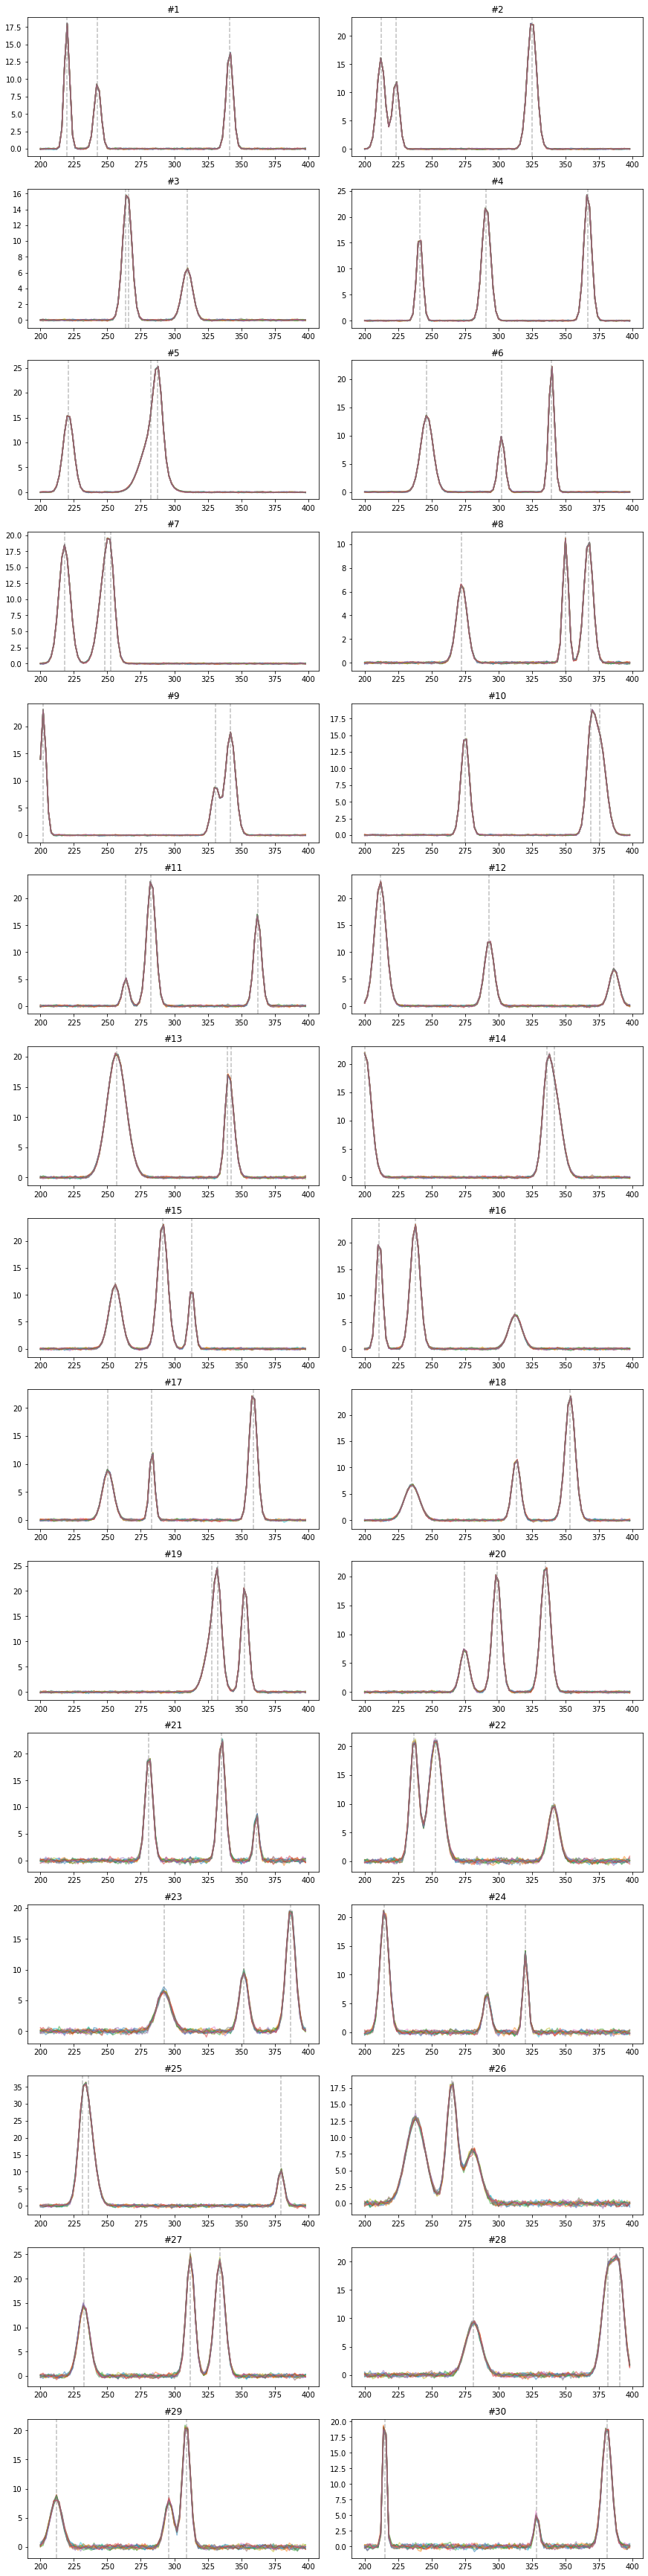

In [6]:
# plot datasets
fig.plot_datasets(ldata, lpeaks, dims=(15,2), figure_size=(12,48), savefig='yes', fname=file_basename)

# Initialize models and run inference

In [7]:
# convert pandas data to numpy arrays
x_val = np.array(xval, dtype='float32')

# store dataset y-values in list
cols = ldata[0].columns
y_val = [ldata[i][cols].values for i in range(len(ldata))]

In [ ]:
# initialize models and run inference
models = []
traces = []

for i in range(len(ldata)):
    if peak_info == 'yes':
        plist = lpeaks[i].flatten()
        plist.sort()
        model_g = mdl.model_gauss(xvalues=x_val, observations=y_val[i], npeaks=3, mu_peaks=plist)
    else:
        model_g = mdl.model_gauss(xvalues=x_val, observations=y_val[i], npeaks=3)      
    models.append(model_g)
    
    with model_g:
        if model_mode == 'train':
            print("running inference on dataset #{0}/{1}".format(i+1,len(ldata)))
            trace_g = pm.sample(2000, init=init_mode)
            traces.append(trace_g)
            # save inference results
            pm.backends.text.dump(out_path + '/traces_%02d' % (i+1), trace_g)
        else:
            # load traces from disk
            print("loading dataset #{0}/{1}".format(i+1,len(ldata)))
            trace_g = pm.backends.text.load(out_path + '/traces_%02d' % (i+1))
            traces.append(trace_g)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #1/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [04:15<00:00, 19.54draws/s] 
The acceptance probability does not match the target. It is 0.9351903206646686, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9996916264871428, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #2/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 275 divergences: 100%|██████████| 5000/5000 [01:27<00:00, 57.46draws/s]
The acceptance probability does not match the target. It is 0.9362116731107926, but should be close to 0.8. Try to increase the number of tuning steps.
There were 275 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5772194784701195, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #3/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 1,573 divergences: 100%|██████████| 5000/5000 [10:05<00:00,  8.26draws/s] 
There were 1444 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.06373591092941484, but should be close to 0.8. Try to increase the number of tuning steps.
There were 129 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #4/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 1,094 divergences: 100%|██████████| 5000/5000 [00:51<00:00, 96.93draws/s] 
The acceptance probability does not match the target. It is 0.9965169931405307, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1094 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.15276737858094605, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #5/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 851 divergences: 100%|██████████| 5000/5000 [00:48<00:00, 103.01draws/s]
There were 851 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.1529316741527712, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.980004258292733, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #6/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 3,162 divergences: 100%|██████████| 5000/5000 [00:34<00:00, 144.34draws/s]
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1163 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.11551760477150198, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #7/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 1,999 divergences: 100%|██████████| 5000/5000 [03:04<00:00, 27.16draws/s] 
The acceptance probability does not match the target. It is 0.9820853583173949, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #8/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:57<00:00, 86.80draws/s] 
The acceptance probability does not match the target. It is 0.9895413149446873, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9408240984343467, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #9/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 1,563 divergences: 100%|██████████| 5000/5000 [00:39<00:00, 128.13draws/s]
There were 1563 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.017774299730041493, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.977129554413176, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #10/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 1,329 divergences: 100%|██████████| 5000/5000 [08:26<00:00,  9.88draws/s] 
There were 1329 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.20491484350327963, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9847925038925389, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #11/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 574 divergences: 100%|██████████| 5000/5000 [01:14<00:00, 67.50draws/s] 
There were 574 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3001128774877082, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.99878284730706, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #12/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 3,472 divergences: 100%|██████████| 5000/5000 [00:40<00:00, 124.15draws/s]
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1473 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.02091854875507898, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #13/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 1,999 divergences: 100%|██████████| 5000/5000 [08:53<00:00,  9.36draws/s] 
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9983046657377936, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #14/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 838 divergences: 100%|██████████| 5000/5000 [01:44<00:00, 48.04draws/s] 
The acceptance probability does not match the target. It is 0.9515207424432135, but should be close to 0.8. Try to increase the number of tuning steps.
There were 838 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.08415697768483084, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #15/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 922 divergences: 100%|██████████| 5000/5000 [00:42<00:00, 116.54draws/s]
There were 922 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.024623335547837445, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.990906249065584, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #16/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 2,000 divergences: 100%|██████████| 5000/5000 [01:49<00:00, 45.55draws/s] 
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9995530126014024, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #17/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [01:50<00:00, 45.25draws/s] 
The acceptance probability does not match the target. It is 0.9993850949605129, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8976946721029443, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #18/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 1,999 divergences: 100%|██████████| 5000/5000 [00:55<00:00, 89.73draws/s] 
The acceptance probability does not match the target. It is 0.9965981066726896, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 5.474482759093455e-90, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #19/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [02:23<00:00, 34.75draws/s] 
The acceptance probability does not match the target. It is 0.9951039668164818, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9393751882563481, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #20/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [01:17<00:00, 64.64draws/s] 
The acceptance probability does not match the target. It is 0.9832891881347695, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9990740907592944, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #21/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 1,999 divergences: 100%|██████████| 5000/5000 [01:59<00:00, 41.88draws/s] 
The acceptance probability does not match the target. It is 0.9994847612973925, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #22/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [04:35<00:00, 18.16draws/s] 
The acceptance probability does not match the target. It is 0.9730512440877994, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9126825881045343, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #23/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:44<00:00, 113.35draws/s]
The acceptance probability does not match the target. It is 0.975887434283906, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9930541818845121, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #24/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [01:14<00:00, 67.18draws/s] 
The acceptance probability does not match the target. It is 0.9983462091416334, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9780505085327496, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #25/30


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 867 divergences:  85%|████████▌ | 4260/5000 [05:30<02:04,  5.93draws/s] 

# Model visualization

In [ ]:
pm.model_to_graphviz(models[0])

In [ ]:
# save model figure as image
img = pm.model_to_graphviz(models[0])
img.render(filename=file_basename + '_model', format='png');

# Collect results and save

In [ ]:
# posterior predictive traces
ppc = [pm.sample_posterior_predictive(traces[i], samples=500, model=models[i]) for i in range(len(traces))]

In [ ]:
# various plots to inspect the inference results
varnames = ['amp', 'mu', 'sigma', 'epsilon']

#az.plot_trace(traces[2], varnames, compact=True);
#az.plot_trace(traces[2], varnames, divergences='top');
#az.plot_autocorr(traces[0], varnames);
#az.plot_posterior(traces[2], varnames);

#for idx, trace in enumerate(traces):
#    az.plot_forest(trace, var_names = varnames, r_hat=True, ess=True);

In [ ]:
if model_mode == 'train':
    # collect the results and display
    df = res.get_results_summary(varnames, traces, ppc, y_val, epsilon_real=lnoise)
else:
    # load results from disk
    df = pd.read_csv(file_basename + '.csv')
    df.index += 1
#df.sort_values(by=['r2'])
df

In [ ]:
if model_mode == 'train':
    # save results to .csv
    df.to_csv(file_basename + '.csv', index=False)

# Plot posterior

In [ ]:
fig.plot_posterior(x_val, ldata, traces, ppc, dims=(15,2), figure_size=(12,48), savefig='yes', 
                       fname=file_basename, showpeaks='no')

In [ ]:
fig.plot_posterior(x_val, ldata, traces, ppc, dims=(15,2), figure_size=(12,48), savefig='yes', 
                       fname=file_basename, showpeaks='yes')

In [ ]:
fp = open(out_path + 'settings.txt', 'a')
fp.write('stop : ' + datetime.datetime.now().strftime("%A, %d. %B %Y %I:%M%p") + '\n')
fp.close()